<a href="https://colab.research.google.com/github/ayyucedemirbas/Vision_Transformer/blob/main/Vision_transformer_weather_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline


In [4]:
!ls -al /content/drive/MyDrive/weather

total 15
-rw------- 1 root root 6148 Oct 15 19:55 .DS_Store
drwx------ 2 root root 4096 Oct 15 19:59 test
drwx------ 2 root root 4096 Oct 15 19:59 train


In [5]:
imagePath = "/content/drive/MyDrive/weather/train"
test_path="/content/drive/MyDrive/weather/test"

In [6]:
batch_size=128
img_height = 64
img_width = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePath,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 960 files belonging to 4 classes.
Using 768 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePath, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 960 files belonging to 4 classes.
Using 192 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 179 files belonging to 4 classes.


In [9]:
x_train= tf.concat([x for x, y in train_ds], axis=0)
y_train= tf.concat([y for x, y in train_ds], axis=0)
x_test= tf.concat([x for x, y in test_ds], axis=0)
y_test= tf.concat([y for x, y in test_ds], axis=0)

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
input_shape=(64, 64, 3)
num_classes = 4
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 64, 64, 3)
(128,)


In [12]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

**GAUSSIAN ERROR LINEAR UNIT**

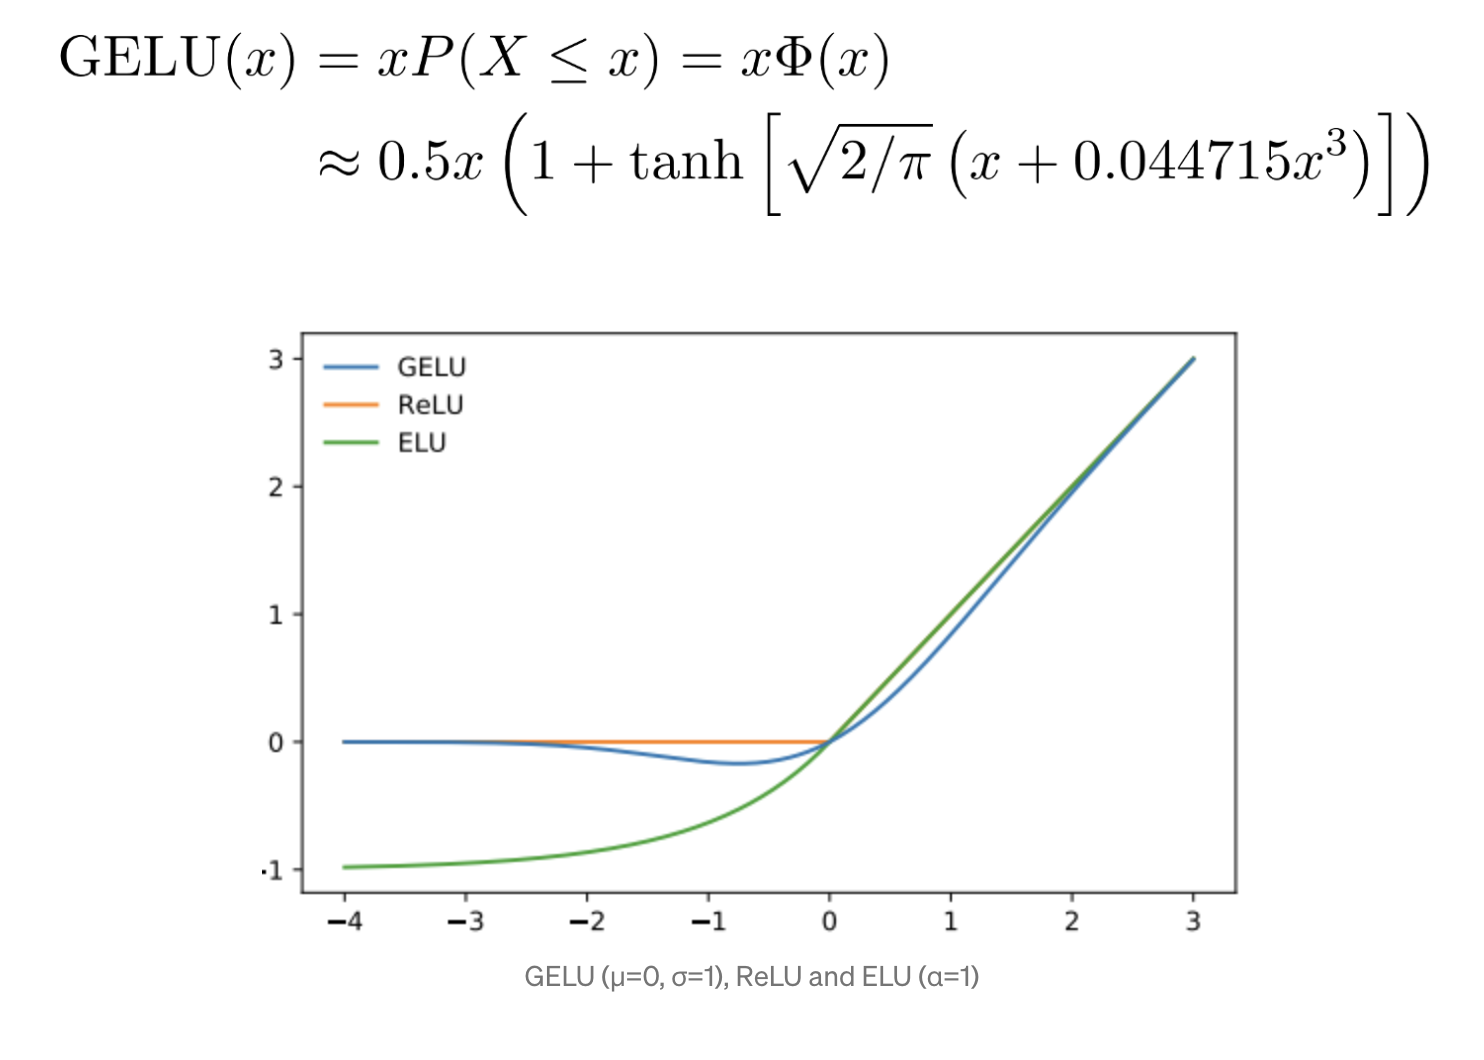

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


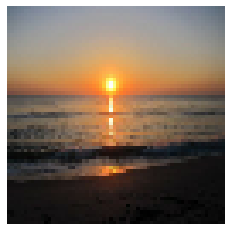

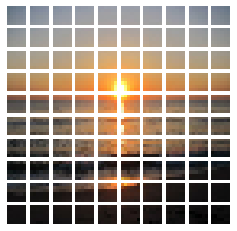

In [15]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
6/6 [==============================] - 13s 468ms/step - loss: 6.7411 - accuracy: 0.2576 - top-5-accuracy: 1.0000 - val_loss: 3.3525 - val_accuracy: 0.3247 - val_top-5-accuracy: 1.0000
Epoch 2/100
6/6 [==============================] - 1s 125ms/step - loss: 3.2922 - accuracy: 0.2562 - top-5-accuracy: 1.0000 - val_loss: 1.8206 - val_accuracy: 0.2468 - val_top-5-accuracy: 1.0000
Epoch 3/100
6/6 [==============================] - 1s 121ms/step - loss: 2.3198 - accuracy: 0.2648 - top-5-accuracy: 1.0000 - val_loss: 1.5116 - val_accuracy: 0.2338 - val_top-5-accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 1s 129ms/step - loss: 1.8346 - accuracy: 0.2851 - top-5-accuracy: 1.0000 - val_loss: 1.5198 - val_accuracy: 0.2208 - val_top-5-accuracy: 1.0000
Epoch 5/100
6/6 [==============================] - 1s 232ms/step - loss: 1.6642 - accuracy: 0.3054 - top-5-accuracy: 1.0000 - val_loss: 1.3890 - val_accuracy: 0.3377 - val_top-5-accuracy: 1.0000
Epoch 6/100
6/6 [=======

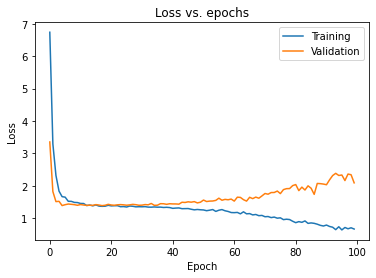

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

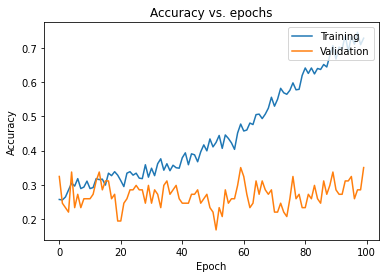

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [21]:
results = vit_classifier.evaluate(test_ds)

2/2 [==============================] - 0s 36ms/step - loss: 1.4551 - accuracy: 0.2737 - top-5-accuracy: 1.0000
